In [1]:
import json
import os

%load_ext dotenv
%dotenv

# f = open("authPaper.json")
# auth = json.load(f)

In [2]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
# BASE_URL = "https://paper-api.alpaca.markets"
# API_KEY = auth['ID']
# SECRET_KEY = auth['Secret']

In [3]:
api = tradeapi.REST(key_id= os.getenv('API_KEY'), secret_key=os.getenv('SECRET_KEY'), base_url=os.getenv('APCA_API_BASE_URL'), api_version='v2')

In [5]:
df_apple = api.get_bars("AAPL", TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

<AxesSubplot:xlabel='timestamp'>

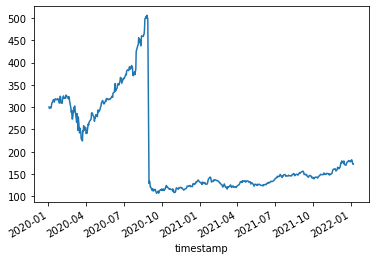

In [6]:
df_apple['close'].plot()

In [7]:
# importing forecasting libraries
import pmdarima as pm
import numpy as npf
import matplotlib.pyplot as plt
import seaborn as sn

In [8]:
arima_model = pm.auto_arima(df_apple['close'], seasonal = False)

# Random Walk (Useless)
A random walk does not help predict the next values only that the variance will increase... lame <br>
This is for predictions involving the closing cost

In [9]:
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting Volume

We can see that volume is dependant on on previous lag with a ar and ma term.

In [10]:
arima_model = pm.auto_arima(df_apple['volume'], seasonal = False)

arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Correlation plot

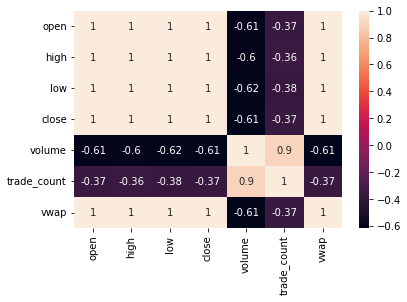

In [11]:
corrMatrix = df_apple.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [19]:
# building linear model
import statsmodels.api as sm
import math
from scipy import stats
from scipy import special
import pandas as pd
import numpy as np

## creating function to automate linear modeling with variables using forecasted predictors

In [20]:
# Setting to be function variables
stock = "AAPL"
test_set_length = 30

In [21]:
df_bars = api.get_bars(stock, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

df_bars

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-01-02 05:00:00+00:00,296.27,300.6000,295.190,300.350,33920004,283490,298.439935
2020-01-03 05:00:00+00:00,296.95,300.5800,296.500,297.430,36633995,280942,298.810386
2020-01-06 05:00:00+00:00,293.70,299.9600,292.750,299.800,29644779,242867,297.799601
2020-01-07 05:00:00+00:00,299.98,300.9000,297.480,298.390,27885664,227873,298.924596
2020-01-08 05:00:00+00:00,297.17,304.4399,297.156,303.190,33091741,261777,301.165533
...,...,...,...,...,...,...,...
2022-01-03 05:00:00+00:00,177.81,182.8800,177.710,182.010,104690466,772367,181.415512
2022-01-04 05:00:00+00:00,182.61,182.9400,179.120,179.700,99284337,831619,180.555450
2022-01-05 05:00:00+00:00,179.61,180.1700,174.650,174.835,86753815,844519,177.497784


Uses BoxCox tranformation to get closer to the norality assumption

In [22]:
transform_variables = ['close', 'volume', 'trade_count']
lambda_fitted = [None] * len(transform_variables)
# transform training data & save lambda value
for ind, variables in enumerate(transform_variables):
    transformed_data, fitted_lambda = stats.boxcox(df_bars[variables])
    
    df_bars[variables] = transformed_data
    
    lambda_fitted[ind] = fitted_lambda

Training and test setting

In [23]:
df_bars_train = df_bars[:-test_set_length]
df_bars_test = df_bars[-test_set_length:]

Fits a linear model using volume and trade_count as predictors with close price as the target

In [24]:
# building linear model
predictors = df_bars[['volume', 'trade_count']]
predictors = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_bars['close'], predictors).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     698.6
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          2.06e-146
Time:                        19:04:54   Log-Likelihood:                 3970.0
No. Observations:                 510   AIC:                            -7934.
Df Residuals:                     507   BIC:                            -7921.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6702      0.001    767.869      0.000       0.669       0.672
volume      -3.927e-05   1.38e-06    -28.486      0.000    -4.2e-05   -3.66e-05
trade_count     0.0028      0.000     16.820      0.000       0.002       0.003
==============================================================================
Omnibus:                       16.005   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.636
Skew:                           0.373   Prob(JB):                     0.000148
Kurtosis:                       3.522   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

adds constant to the test set and then gets the predicted variables from the fitted linear model

In [25]:
new_data_lm = sm.add_constant(df_bars_test[['volume', 'trade_count']])

test_pred_lm = fitted_linear.predict(new_data_lm)

# getting mae for linear model will be used to set trigger for buy and cell
np.mean(np.abs(special.inv_boxcox(test_pred_lm, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0])))

29.597793272764925

forecasting the predictor variables

In [26]:
arima_volume_model = pm.auto_arima(df_bars_train['volume'], seasonal = False)
arima_trade_model = pm.auto_arima(df_bars_train['trade_count'], seasonal = False)

goes through a loop to get a one step ahead forecast adding another observation of data to the original forecasted models <br>
and then saves the forecast to test lists

In [27]:
test_volume_error = []
test_trade_error = []

for i in range((test_set_length), 0, -1):
    
    tmp_volume_model = arima_volume_model
    tmp_trade_model = arima_trade_model

    if (i == 30):
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        test_trade_error.append(arima_trade_model.predict(n_periods = 1)[0])
    else:
        tmp_volume_model.update(df_bars_test[i:].volume)
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        tmp_trade_model.update(df_bars_test[i:].trade_count)
        
        test_trade_error.append(tmp_trade_model.predict(n_periods = 1)[0])

Getting the accuracy measures from the forecasts

In [28]:
# getting mae for volume one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1])))

29364420.787549384

In [29]:
# getting mape for volume
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))/special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))

0.24391169264528267

In [30]:
# getting mae for volume one step ahead for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2])))

191117.93399739065

In [31]:
# mape for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))/ special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))

0.22899063138956996

Using the forecasted predictor values to get estimated target variables and viewing the accuracy

In [32]:
# instead of using the actual testset to test linear model use the forecasted
df_new_forecast = pd.DataFrame({'volume': test_volume_error, 'trade_count': test_trade_error})
# if mape is smaller than .5, we are acurate more than 50% of the time...

df_new_forecast = sm.add_constant(df_new_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [33]:
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True)))

16.17198266696413

In [34]:
# getting standard deviation to see the spread of the data
1.96*np.std(special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]))

12.72382343635026

In [35]:
# mape for the forecasted new dataset using one step ahead forecasts
# getting 10% is pretty great from forecast to a linear model.. 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))/special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))

0.0925037283226495

# Using PCA and applied previous method to predict closing price

In [36]:
# Calls libraries used for pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [37]:
# 50 top stocks
stock_list = ['DIDI', 'AMD', 'AAPL', 'AMZN', 'CCL', 'NIO', 'F', 'BBD', 'ITUB', \
             'ABEV', 'BABA', 'NVDA', 'NOK', 'AAL', 'DOCU', 'SNAP', 'PCG', 'SOFI', \
             'SWN', 'INTC', 'AUY', 'CERN', 'PBR', 'T', 'TSLA', 'GRAB', 'NCLH', \
             'NU', 'MSFT', 'NLY', 'PLTR', 'UBER', 'WFC', 'META', 'XOM', 'MU', \
             'OXY', 'AMC', 'WBD', 'RIG', 'CS', 'OPEN', 'RBLX', 'PFE', 'PDD', \
             'FCX', 'GFI', 'DKNG']

In [38]:
df_group_bars = pd.DataFrame()

# runs through list of stocks and pulls a given stock and concatinates that onto a main df. it also creates a stock column,
# which is just the stock name
for stocks in stock_list:
    
    if (len(df_group_bars) == 0):
        
        df_group_bars = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_group_bars['stock'] = stocks
    else:
    
        df_temp_stock = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_temp_stock['stock'] = stocks
        
        df_group_bars = pd.concat([df_group_bars, df_temp_stock])

In [39]:
# Sets up for data pivot to wider
df_group_bars['datetime'] = df_group_bars.index
df_group_bars['datetime'] = pd.to_datetime(df_group_bars['datetime'])
# df_group_bars.pivot(index='patient', columns='obs', values='score')

In [40]:
# pivots data
df_pivot_bars = df_group_bars.pivot(index='datetime', columns='stock', values=['close', 'volume', 'trade_count'])

In [41]:
# drops multi index from pivot
df_pivot_bars.columns = df_pivot_bars.columns.get_level_values(0) + '_' +  df_pivot_bars.columns.get_level_values(1)

In [42]:
# picking the target variable, of course I'm choosing Apple
target = df_pivot_bars.pop('close_AAL')

In [43]:
# scalling the data for pca
df_scaled_bars = StandardScaler().fit_transform(df_pivot_bars.dropna(axis = 'columns'))

In [44]:
# Afters short analysis, I have chosen to get only 5 pca
pca = PCA(n_components = 5)

principalComponents = pca.fit_transform(df_scaled_bars)

principalDf = pd.DataFrame(data = principalComponents)

principalDf['Target'] = target.reset_index(drop = True)

transformed_principal, fitted_lambda = stats.boxcox(principalDf['Target'])

principalDf['Target'] = transformed_principal

<AxesSubplot:>

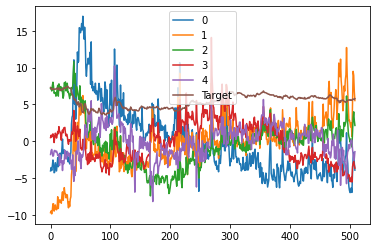

In [45]:
principalDf.plot()

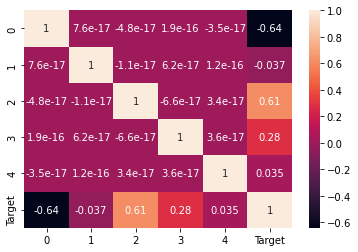

In [46]:
# correlation plot with target and pca
corrMatrix = principalDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [47]:
df_pca_train = principalDf[30:]
df_pca_test =  principalDf[:30]

In [48]:
# building linear model
predictors = df_pca_train[[0,1,2,3,4]]
predictors_cons = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_pca_train['Target'], predictors_cons).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     494.9
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          1.55e-185
Time:                        19:05:18   Log-Likelihood:                -166.41
No. Observations:                 480   AIC:                             344.8
Df Residuals:                     474   BIC:                             369.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4366      0.017    326.885      0.000       5.404       5.469
0             -0.1253      0.003    -37.957      0.000      -0.132      -0.119
1             -0.0039      0.006     -0.661      0.509      -0.015       0.008
2              0.1626      0.006     26.805      0.000       0.151       0.175
3              0.0923      0.006     16.550      0.000       0.081       0.103
4              0.0192      0.007      2.585      0.010       0.005       0.034
==============================================================================
Omnibus:                        2.978   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                3.071
Skew:                           0.084   Prob(JB):                        0.215
Kurtosis:                       3.354   Cond. No.                         5.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Generates a fitted forecast of each pca and then saves each one into a list

In [49]:
forecast_list = []
for col in df_pca_train.columns:
    forecast_list.append(pm.auto_arima(df_pca_train[col], seasonal = False))

In [50]:
df_step_ahead_forecast = pd.DataFrame()

# for loops goes through each predictor column and then gets a one step ahead forecast by slowing updating the fitted models
# with one more observation using a for loop. The forecasted values are then saved to a dataframe
for col in df_pca_test.columns[:-1]:
    
    test_forecast = []
    
    forecast_model_col = forecast_list[col]
    
    for i in range(len(df_pca_test), 0, -1):
        
        tmp_forecast_model = forecast_model_col
        
        if (i == 30):
        
            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
        else:
            
            tmp_forecast_model.update(df_pca_test[col][i:])

            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
    
    df_step_ahead_forecast[col] = test_forecast

Gets predicted values from the linear model using the forecasted predictor values

In [51]:
df_new_forecast = sm.add_constant(df_step_ahead_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [52]:
# mae for forecasted variables as predictors of the closed amount.
# 2 dollars is a pretty decent mae 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)))

2.1630875820767526

In [53]:
np.std(special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

1.0029007373059866

In [54]:
# mape for the forecasted new dataset using one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)) / special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

0.0759559805339844

In [55]:
# possible bias in these models... It is always lower than the actual
special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)

0    -9.439807
1    -4.211824
2    -2.530760
3    -1.586696
4    -1.834772
5    -1.820192
6    -1.114520
7    -1.160303
8    -1.299568
9    -1.362573
10   -2.028375
11   -2.199688
12   -1.008740
13   -1.126602
14   -2.609325
15   -1.448910
16    0.084667
17   -0.703561
18   -0.600872
19   -1.515702
20   -0.632464
21   -0.949225
22   -2.217766
23   -2.886845
24   -2.084395
25   -2.160448
26   -2.565555
27   -3.612085
28   -4.239865
29   -3.856523
dtype: float64

## MacD analysis

In [56]:
# inport necessary libraries
import talib as tb

In [57]:
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [67]:
# creates a macD dataframe using talib and then merges original dataset onto it
df_mac = pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist':macdhist})

df_mac = df_mac.merge(df_apple, left_index=True, right_index=True)

In [82]:
# shisfts close back one to get tomorrow's close price
df_mac['next_day_close'] = df_mac['close'].shift(periods=-1, axis="index")

In [84]:
# creates a boolean columns on if the next day is higher than the previous
df_mac['higher_than_yesterday'] = np.where(df_mac['next_day_close'] > df_mac['close'], 1, 0)

In [86]:
# prints out dataframe
df_mac

,macd,macdsignal,macdhist,open,high,low,close,volume,trade_count,vwap,close_shift,previous_day,next_day_close,higher_than_yesterday
timestamp,,,,,,,,,,,,,,
2020-01-02 05:00:00+00:00,NaN,NaN,NaN,296.27,300.6000,295.190,300.350,33920004,283490,298.439935,NaN,297.430,297.430,0
2020-01-03 05:00:00+00:00,NaN,NaN,NaN,296.95,300.5800,296.500,297.430,36633995,280942,298.810386,300.350,299.800,299.800,1
2020-01-06 05:00:00+00:00,NaN,NaN,NaN,293.70,299.9600,292.750,299.800,29644779,242867,297.799601,297.430,298.390,298.390,0
2020-01-07 05:00:00+00:00,NaN,NaN,NaN,299.98,300.9000,297.480,298.390,27885664,227873,298.924596,299.800,303.190,303.190,1
2020-01-08 05:00:00+00:00,NaN,NaN,NaN,297.17,304.4399,297.156,303.190,33091741,261777,301.165533,298.390,309.630,309.630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 05:00:00+00:00,4.818780,4.982143,-0.163363,177.81,182.8800,177.710,182.010,104690466,772367,181.415512,177.570,179.700,179.700,0
2022-01-04 05:00:00+00:00,4.672654,4.920245,-0.247591,182.61,182.9400,179.120,179.700,99284337,831619,180.555450,182.010,174.835,174.835,0
2022-01-05 05:00:00+00:00,4.116827,4.759562,-0.642734,179.61,180.1700,174.650,174.835,86753815,844519,177.497784,179.700,172.000,172.000,0


In [98]:
df_mac_nona = df_mac.loc[(~df_mac['macdhist'].isna()) & ~(df_mac['previous_day'].isna()),]

In [99]:
df_mac_nona

,macd,macdsignal,macdhist,open,high,low,close,volume,trade_count,vwap,close_shift,previous_day,next_day_close,higher_than_yesterday
timestamp,,,,,,,,,,,,,,
2020-02-20 05:00:00+00:00,3.734878,4.484113,-0.749236,322.63,324.65,318.21,320.300,25641564,243578,321.110904,323.620,313.050,313.050,0
2020-02-21 05:00:00+00:00,2.803147,4.147920,-1.344773,318.78,320.45,310.50,313.050,32426415,323163,314.536221,320.300,298.180,298.180,0
2020-02-24 05:00:00+00:00,0.855003,3.489337,-2.634334,297.00,304.18,289.23,298.180,55652191,586890,299.479483,313.050,288.080,288.080,0
2020-02-25 05:00:00+00:00,-1.486762,2.494117,-3.980879,300.64,302.53,286.13,288.080,57670139,624805,293.221205,298.180,292.650,292.650,1
2020-02-26 05:00:00+00:00,-2.939977,1.407298,-4.347275,286.52,297.88,286.50,292.650,49680634,494246,292.894821,288.080,273.520,273.520,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 05:00:00+00:00,4.699999,5.022984,-0.322985,178.00,179.23,177.26,177.570,64038680,451478,177.800285,178.200,182.010,182.010,1
2022-01-03 05:00:00+00:00,4.818780,4.982143,-0.163363,177.81,182.88,177.71,182.010,104690466,772367,181.415512,177.570,179.700,179.700,0
2022-01-04 05:00:00+00:00,4.672654,4.920245,-0.247591,182.61,182.94,179.12,179.700,99284337,831619,180.555450,182.010,174.835,174.835,0


In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define the model
random_forest_macd = RandomForestClassifier()
# evaluate the model
random_forest_macd.fit(df_mac_nona[['previous_day','macdhist']], df_mac_nona['higher_than_yesterday'])

RandomForestClassifier()

completely random

In [103]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(random_forest_macd, df_mac_nona[['previous_day','macdhist']], df_mac_nona['higher_than_yesterday'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.494 (0.078)


In [ ]:
# let's build no model and just get the percentage of being above the certain shift forwards. Use difference between the
# macd to use a velocity... maybe the faster the machhist the more likely the closing price will be maintain a trend.